# Geographic Sensor Data Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from shapely.geometry import Point
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.colors as mcolors

### Global Functions

In [2]:
def manual_tofloat(val):
    try:
        return float(val)
    except Exception:
        return float('NaN')

In [260]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def predictability_risk_map(base, sensor_data, sensor_locations, sensor_type='Purple Air', site_id_key='Site_ID', graph_type='nodes'):
    sensor_corrs = sensor_data.corr(method='pearson')
    corr_threshold = 0

    G = nx.Graph()

    # Add nodes (points)
    for i, point in enumerate(sensor_locations.geometry):
        G.add_node(i, pos=(point.x, point.y))

    predictability = []
    node_type = []
    # Add edges (correlations based on distance)
    for i in range(len(sensor_locations)):
        sensor_i = sensor_locations[site_id_key][i]
        sensor_i_corrs = sensor_corrs[sensor_i]
        
        for j in range(i + 1, len(sensor_locations)):
            sensor_j = sensor_locations[site_id_key][j]
            corr = sensor_i_corrs[sensor_j]            
            
            if corr == corr and abs(corr) > corr_threshold:
                G.add_edge(i, j, weight=corr)
            
        predictability.append(sensor_i_corrs[sensor_i_corrs.index != sensor_i].max())
        node_type.append(sensor_locations.loc[i, 'sensor_type'])
        
        pos = {i: (sensor_locations.geometry[i].x, sensor_locations.geometry[i].y) for i in range(len(sensor_locations))}


    fig, ax = plt.subplots(figsize=(8, 8))

    tract_cmap_str = 'Greys'

    base.plot(
        column='S2701_C05_001E', 
        edgecolor='black',
        cmap=plt.cm.Greys,
        markersize=3,
        missing_kwds={
            'color': 'lightgrey',
            'edgecolor': 'red',
            'hatch': '///',
            'label': 'No data'
        },
        ax=ax
    )

    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    edge_width = list(map(lambda w: 5*w**35, weights))
    edge_cmap = plt.cm.Blues
    node_cmap = plt.cm.winter
    tract_cmap = plt.cm.Greys
    
    edges_sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=mcolors.Normalize(vmin=0.24, vmax=1))#vmin=min(weights), vmax=max(weights)))
    edges_sm.set_array([])
    
    if graph_type == 'network':
        fig.colorbar(edges_sm, ax=ax, orientation="vertical", label="Sensor Correlation", fraction=0.045)
        #cbar = fig.colorbar(edges_sm, ax=ax, orientation="vertical", label="Sensor Correlation", fraction=0.045, pad=0.01)
        #cbar.ax.set_position([0.858, 0.188, 1, 0.6535])

    nodes_sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=mcolors.Normalize(vmin=0.82, vmax=1))#vmin=min(predictability), vmax=max(predictability)))
    nodes_sm.set_array([])
    
    if graph_type == 'node':
        fig.colorbar(nodes_sm, ax=ax, orientation="vertical", label="Predictability Index", fraction=0.045)
        #cbar = fig.colorbar(nodes_sm, ax=ax, orientation="vertical", label="Predictability Index", fraction=0.045, pad=0.01)
        #cbar.ax.set_position([0.858, 0.188, 1, 0.6535])
        
    tract_sm = plt.cm.ScalarMappable(cmap=tract_cmap, norm=mcolors.Normalize(vmin=ins_mapping['S2701_C05_001E'].min(), vmax=ins_mapping['S2701_C05_001E'].max()))
    tract_sm.set_array([])
    fig.colorbar(tract_sm, ax=ax, orientation="horizontal", label="Percentage of Total Population Uninsured (ACS Estimate)", pad=0.0)

    # Plot the edges (connections between points)
    if graph_type == 'network':
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color=weights, width=edge_width, alpha=0.3, edge_cmap=edge_cmap)        
    
    # Plot the nodes (points) on top of the map
    if graph_type == 'node':
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color=predictability, node_size=20, cmap=node_cmap, label=f'{sensor_type} Sensors')
    else:
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color='darkblue', node_size=20, label=f'{sensor_type} Sensors')
    
    title = 'Sensor Predictability over Percentage Uninsured'
    
    if graph_type == 'network':
        title = 'Sensor Correlations over Percentage Uninsured'
    
    ax.set_title(title)
    #plt.xlabel('Longitude')
    #plt.ylabel('Latitude')
    ax.set_ylim([37.60,37.68])
    ax.set_xlim([-122.48, -122.36])

    plt.legend()
    plt.show()
    
    return ax

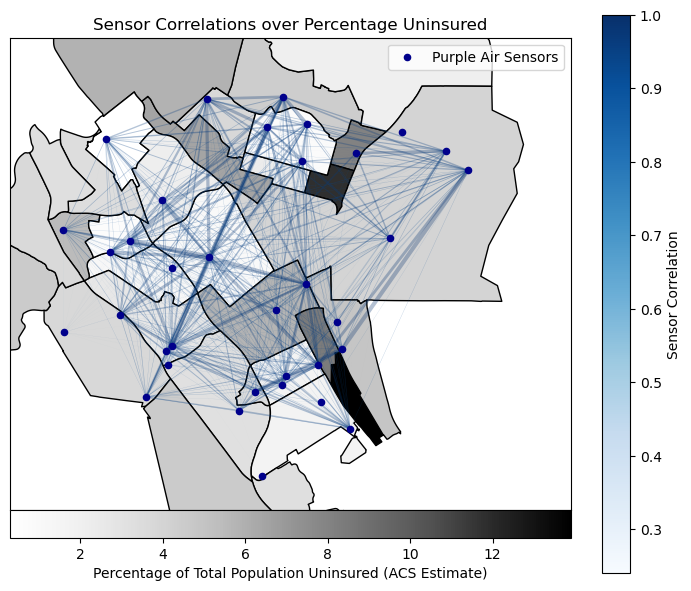

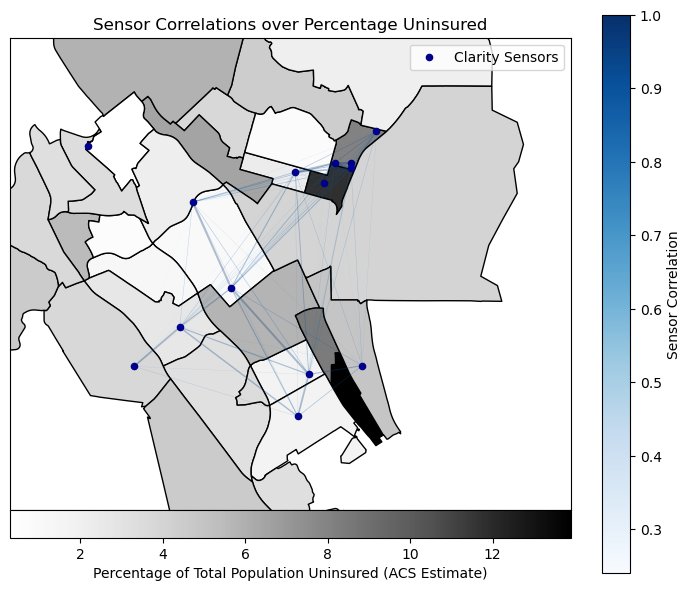

In [262]:
purple_predictability_risk_map = predictability_risk_map(ins_mapping, hourly_asds_pivot, metadata, graph_type='network')
clarity_predictability_risk_map = predictability_risk_map(ins_mapping, clarity_data_pivot, clarity_metadata, sensor_type='Clarity', site_id_key='datasourceId', graph_type='network')

In [100]:
clarity_metadata

,datasourceId,locationLatitude,locationLongitude,geometry
0,DCVIM2201,37.63757000,122.43270000,POINT (37.638 -122.433)
1,DETMG3939,37.65875000,122.41055000,POINT (37.659 -122.411)
2,DEVPF7186,37.65721000,122.41898000,POINT (37.657 -122.419)
3,DHPSP8686,37.65876000,122.40700000,POINT (37.659 -122.407)
4,DHSHV3008,37.65544000,122.41276000,POINT (37.655 -122.413)
5,DJGNN5114,37.62292000,122.41611000,POINT (37.623 -122.416)
6,DJTYV8538,37.61580000,122.41844000,POINT (37.616 -122.418)
7,DMEYT2138,37.65214000,122.44095000,POINT (37.652 -122.441)
8,DNSEJ7404,37.66170000,122.46329000,POINT (37.662 -122.463)
9,DRCAC7970,37.62441000,122.40469000,POINT (37.624 -122.405)


In [101]:
metadata

,Site_ID,Date_Created,Site_Name,Model,Hardware,Firmware_Version,Firmware_Upgrade,Latitude,Longitude,Elevation,County,Geohash_4,Geohash_5,Geohash_6,Geohash_7,Imposter_Sensors,Indoor_Sensors,Problematic_Sensors,geometry
0,20737,12/5/18 12:24,AZ South San Francisco,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.664036,-122.39622,20,San Mateo,9q8y,9q8yq,9q8yqb,9q8yqb9,False,False,False,POINT (-122.39622 37.66404)
1,21427,12/11/18 12:53,Grundy Park,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.622585,-122.42097,86,San Mateo,9q8y,9q8yn,9q8yn0,9q8yn0z,False,False,False,POINT (-122.42097 37.62259)
2,38589,8/29/19 8:32,Sign Hill,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.665333,-122.41648,261,San Mateo,9q8y,9q8yq,9q8yq2,9q8yq2g,False,False,False,POINT (-122.41648 37.66533)
3,60171,7/23/20 14:31,South San Francisco Westborough Park,PA-II-SD,2.0+OPENLOG+NO-DISK+DS3231+BME280+PMSX003-B+PM...,7.02,,37.64361,-122.45865,436,San Mateo,9q8y,9q8yj,9q8yjk,9q8yjku,False,False,False,POINT (-122.45865 37.64361)
4,65711,9/4/20 8:20,Commodore Dr,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.63386,-122.42311,76,San Mateo,9q8y,9q8yn,9q8yn5,9q8yn5n,False,False,False,POINT (-122.42311 37.63386)
5,67263,9/9/20 13:27,Danger Stairs,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.662823,-122.45957,168,San Mateo,9q8y,9q8ym,9q8ym2,9q8ym27,False,False,False,POINT (-122.45957 37.66282)
6,67419,9/10/20 7:45,Acacia And Crystal Springs,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.61825,-122.41345,51,San Mateo,9q8y,9q8yn,9q8yn2,9q8yn2j,False,False,False,POINT (-122.41345 37.61825)
7,68487,9/14/20 11:40,Belle Air,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.62725,-122.40895,12,San Mateo,9q8y,9q8yn,9q8yn9,9q8yn9b,False,False,False,POINT (-122.40895 37.62725)
8,69403,9/17/20 14:34,"Sunshine Gardens, SSF",PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.6696,-122.43797,164,San Mateo,9q8y,9q8ym,9q8ymc,9q8ymce,False,False,False,POINT (-122.43797 37.66960)
9,70569,9/22/20 9:18,Rollingwood / Palmhaus,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,7.02,,37.62681,-122.44654,545,San Mateo,9q8y,9q8yj,9q8yj9,9q8yj9v,False,False,False,POINT (-122.44654 37.62681)


### Census Tracts

In [4]:
ssf_tracts = [
    '6001P',
    '6017',
    '6018P',
    '6018',
    '6019',
    '6019.01',
    '6019.02',
    '6020P',
    '6020.01',
    '6020.02',
    '6021',
    '6022',
    '6022.02',
    '6022.01',
    '6023P',
    '6024P',
    '6024',
    '6025',
    '6026',
    '6026.01',
    '6026.02',
    '6038.01',
    '6038.02',
    '6039',
    '6040',
    '6041.02P',
    '6041.03',
    '6041.04',
    '6042P'
]
sb_tracts = [
    '6023P',
    '6030P',
    '6035P',
    '6036P',
    '6037',
    '6038P',
    '6039P',
    '6040',
    '6041.01P',
    '6041.02P',
    '6042P',
    '6046P',
    '6135.01P'
]

other_tracts = [
    '6016.01',
    '6027',
    '6140',
    '6016.03',
    '6016.05'
]

tracts = ssf_tracts + sb_tracts + other_tracts

# Tracts in the shapefile don't contain 'P'
reformat = lambda tract: tract.replace('P', '')
tracts_reformatted = list(map(reformat, tracts))

In [5]:
census_tracts = gpd.read_file('../shapefiles/tl_2024_06_tract.shp')
census_tracts['NAME'] = census_tracts['NAME'].astype(str)

In [6]:
ssf_sb_tracts = census_tracts[(census_tracts['COUNTYFP'] == '081') & census_tracts['NAME'].isin(tracts_reformatted)]

### Health Insurance Coverage

In [7]:
health_ins_coverage = gpd.read_file('../data/ACSST5Y2023.S2701-Data.csv')[1:]

In [8]:
ex_tract = lambda name: name.split('Census Tract')[-1].split(';')[0].strip()
health_ins_coverage['NAME'] = health_ins_coverage['NAME'].apply(ex_tract).astype(str)
health_ins_coverage['S2701_C05_001E'] = health_ins_coverage['S2701_C05_001E'].astype(float)

In [9]:
ins_mapping = ssf_sb_tracts.join(health_ins_coverage.set_index('NAME')[['S2701_C05_001E']], on='NAME')

### Purple and Clarity Data

In [10]:
daily_asds = gpd.read_file('../data/Daily ASDS 2018-2023 for South San Francisco San Bruno.csv')
hourly_asds = gpd.read_file('../data/Hourly ASDS 2018-2023 for South San Francisco San Bruno.csv')

In [118]:
metadata = gpd.read_file('../data/ASDS 2018-2023 for South San Francisco and San Bruno Metadata.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
metadata['sensor_type'] = 'purple'

In [11]:
hourly_asds['PM2.5_EPA'] = hourly_asds['PM2.5_EPA'].apply(manual_tofloat)
hourly_asds_pivot = hourly_asds.pivot(index='Datetime', columns='Site_ID', values='PM2.5_EPA')

In [56]:
clarity_data = gpd.read_file('../data/Hourly Clarity Data 1-24 to 1-25.csv')

KeyError: 'Datasource.ID'

In [117]:
clarity_data_geo = gpd.GeoDataFrame(   
    clarity_data, 
    geometry=gpd.points_from_xy(-clarity_data['locationLongitude'].astype(float), clarity_data['locationLatitude'].astype(float)), 
    crs="EPSG:4326"
)
clarity_metadata = clarity_data_geo.groupby(['datasourceId']).first()[['locationLatitude', 'locationLongitude', 'geometry']].reset_index()
clarity_metadata['sensor_type'] = 'clarity'

In [67]:
clarity_data['pm2_5ConcMass1HourMean.value'] = clarity_data['pm2_5ConcMass1HourMean.value'].apply(manual_tofloat)
clarity_data_pivot = clarity_data.pivot(index='startOfPeriod', columns='datasourceId', values='pm2_5ConcMass1HourMean.value')

In [70]:
clarity_data_pivot

datasourceId,DCVIM2201,DETMG3939,DEVPF7186,DHPSP8686,DHSHV3008,DJGNN5114,DJTYV8538,DMEYT2138,DNSEJ7404,DRCAC7970,DRYLF3821,DTMSK2119,DUBTA4581,DVRGV9737
startOfPeriod,,,,,,,,,,,,,,
2024-10-30T17:00:00.000Z,NaN,NaN,NaN,NaN,25.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-30T18:00:00.000Z,NaN,NaN,NaN,NaN,24.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-30T19:00:00.000Z,NaN,NaN,NaN,NaN,33.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-30T20:00:00.000Z,NaN,NaN,NaN,NaN,25.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-30T21:00:00.000Z,NaN,NaN,NaN,NaN,12.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01T12:00:00.000Z,6.33,13.87,14.45,16.16,10.96,6.87,4.43,5.51,5.56,5.48,11.34,6.55,8.91,15.59
2025-01-01T13:00:00.000Z,10.99,12.46,13.73,15.03,15.44,12.49,6.73,5.45,10.04,7.16,11.01,11.99,13.25,12.49
2025-01-01T14:00:00.000Z,14.23,17.35,13.22,18.23,17.42,12.53,9.87,9.57,11.95,9.19,14.34,9.61,8.19,12.25


### Plots

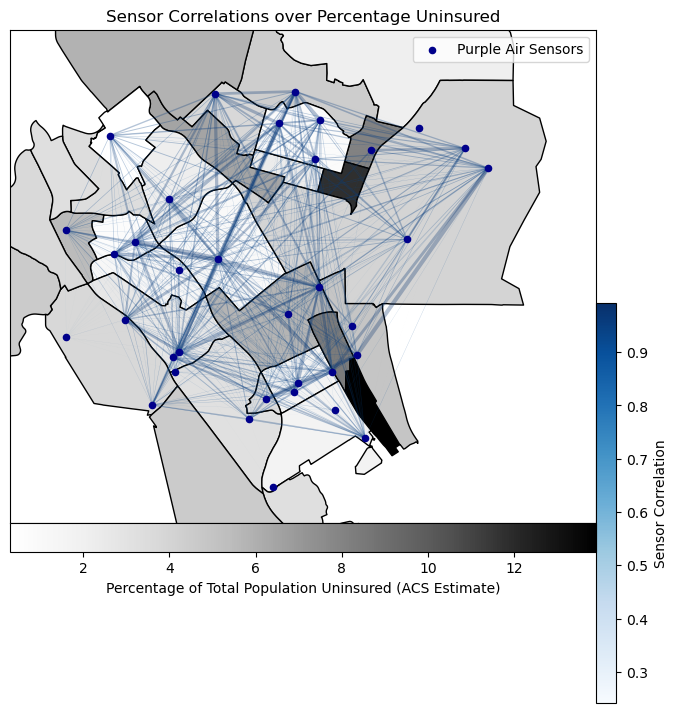

In [199]:
purple_predictability_risk_map = predictability_risk_map(ins_mapping, hourly_asds_pivot, metadata, graph_type='network')
#clarity_predictability_risk_map = predictability_risk_map(ins_mapping, clarity_data_pivot, clarity_metadata, sensor_type='Clarity', site_id_key='datasourceId', graph_type='network')

In [122]:
hourly_asds_pivot

Site_ID,104538,107708,109506,109718,111235,111498,113144,119179,120937,131431,...,69403,70569,70679,76803,78387,81205,86761,90215,91617,94137
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-27 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-27 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-27 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-27 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-27 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,NaN,NaN,NaN,9.004847,NaN,2.196140,1.688253,NaN,8.008907,NaN,...,8.674080,8.743753,9.649360,NaN,5.924493,NaN,5.724973,13.373393,4.841767,5.274333
2023-12-31 20:00:00,NaN,NaN,NaN,13.143613,NaN,5.331253,2.352533,NaN,14.195420,NaN,...,10.410460,7.503507,16.208767,NaN,10.067080,NaN,9.660100,7.731153,4.906733,6.428634
2023-12-31 21:00:00,NaN,NaN,NaN,10.757273,NaN,10.111640,5.605613,NaN,15.481613,NaN,...,10.971547,11.408269,12.877113,NaN,13.724587,NaN,10.675033,13.414193,13.300380,11.453207
